# ECSE415 - Into to Computer Vision
## Assignment 3
### Alexander Harris - 260688155

## 1 - Segmentation
### 1.1 - K-means clustering and Expectation Maximization

In [1]:
import cv2
import numpy as np
import math
import time
from matplotlib import pyplot as plt

img = cv2.imread('./dataset/home.jpg')
img_arr = np.array(img)

In [2]:
def plotFigures(images, title, params=None):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    length = len(images)
    grid_len = math.ceil(math.sqrt(length))
    
    if params:
        params_str = ''.join(['{}={}'.format(key, value) for key, value in params.items()])
    
    plt.figure(figsize=(30, 30))
    for i, image in enumerate(images):
        plt.subplot(grid_len, grid_len, i+1), plt.imshow(image)
        if params:
            plt.title('{} - {} - Iteration: {}/{}'.format(title, params_str, i+1, length)), plt.axis('off')
        else:
            plt.title('{} - Iteration: {}/{}'.format(title, i+1, length)), plt.axis('off')
    plt.show()

In [3]:
def kMeansCluster(arr, k, maxIters=10):
    """
    K-Mean Clustering algortihm for image segmentation.
    
    arr: input image as numpy array
    k: number of cluster centers
    maxIters: maximum number of times to compute
    """
    h, w, d = arr.shape
    images = []
    
    # Init cluster centers
    centers = np.random.random_sample((k, d)) * np.max(arr)
    
    for i in range(maxIters):
        # Find distances and compute clusters
        distances = np.array([arr - c for c in centers])
        distances = np.linalg.norm(distances, axis=-1)
        clusters = np.argmin(distances, axis=0)
        images.append(clusters)
        
        # Compute new cluster centers
        new_centers = np.zeros(shape=(k, d))
        for c in range(k):
            new_centers[c] = np.mean(arr[clusters == c], axis=0)
        centers = new_centers
        
    plotFigures(images, title='K-Means Clustering', params={'K': k})

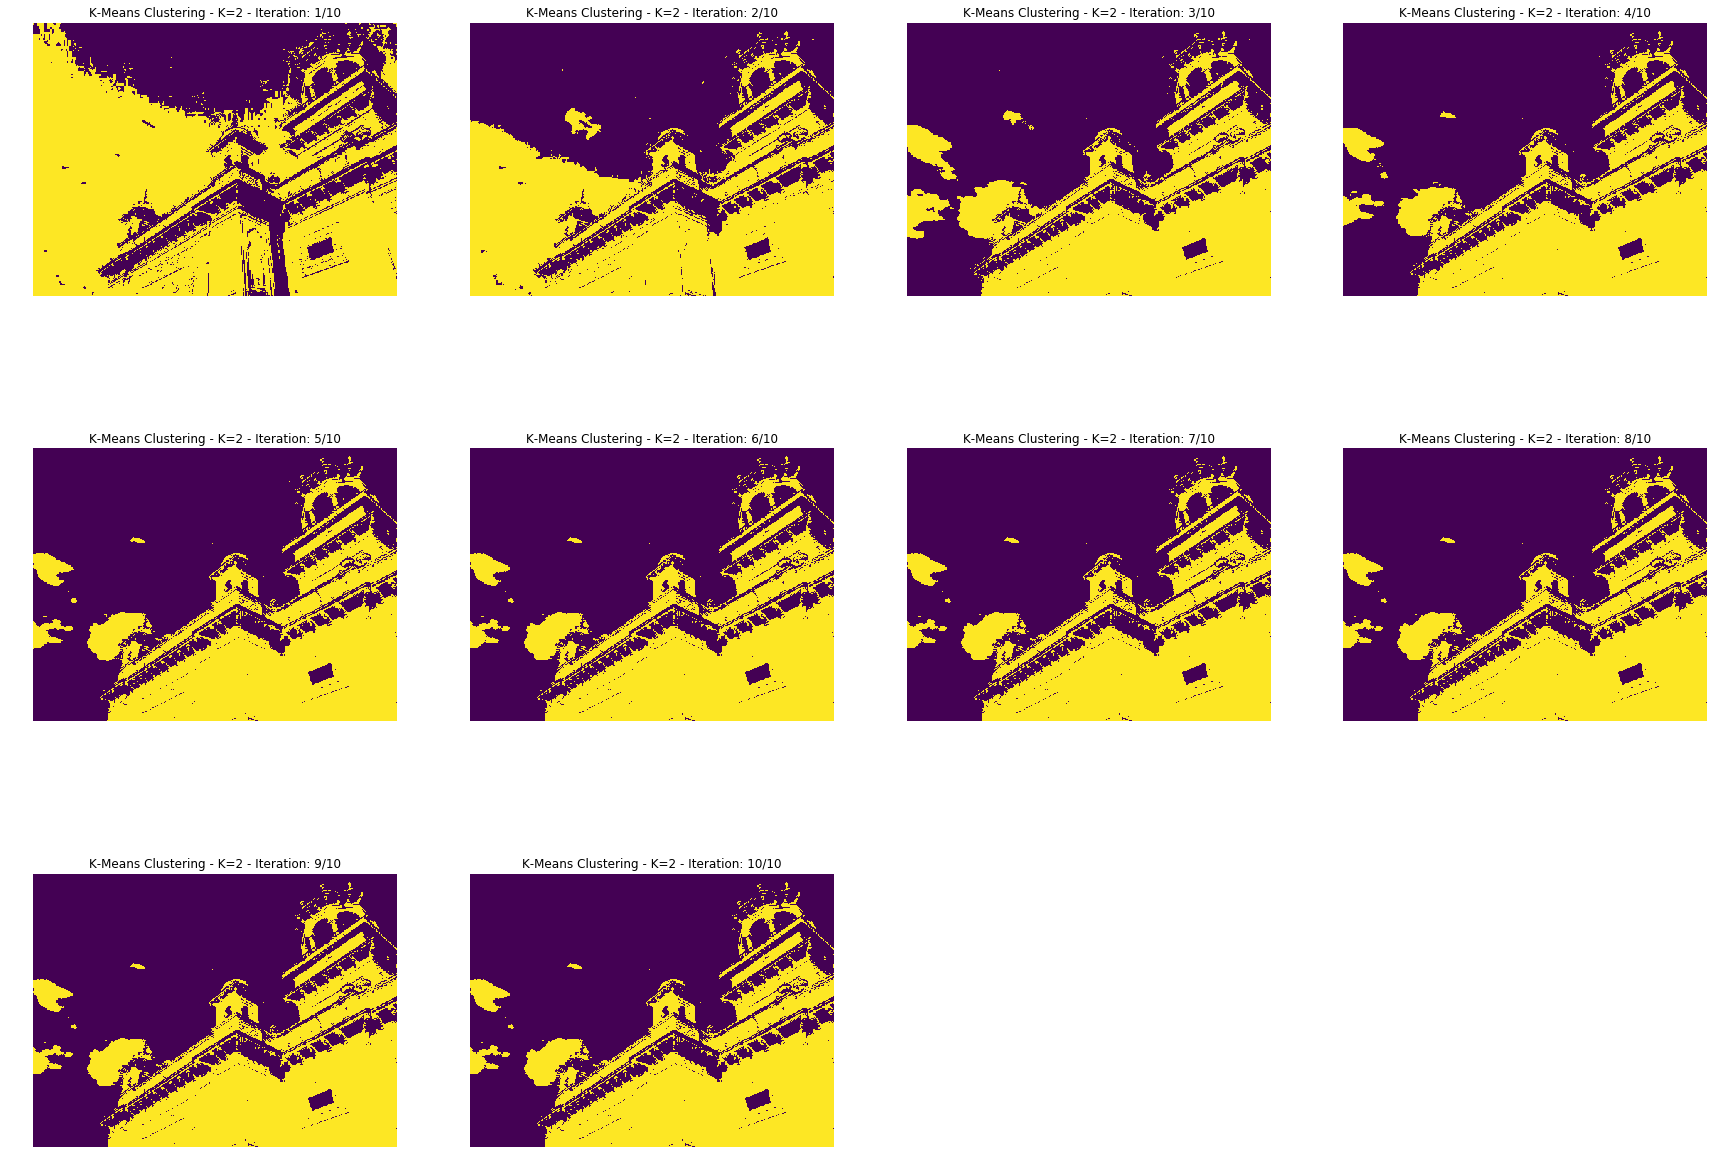

Runtime: 1.4997608661651611 s


In [4]:
start = time.time()
kMeansCluster(img_arr, 2)
print('Runtime:', time.time() - start, 's')

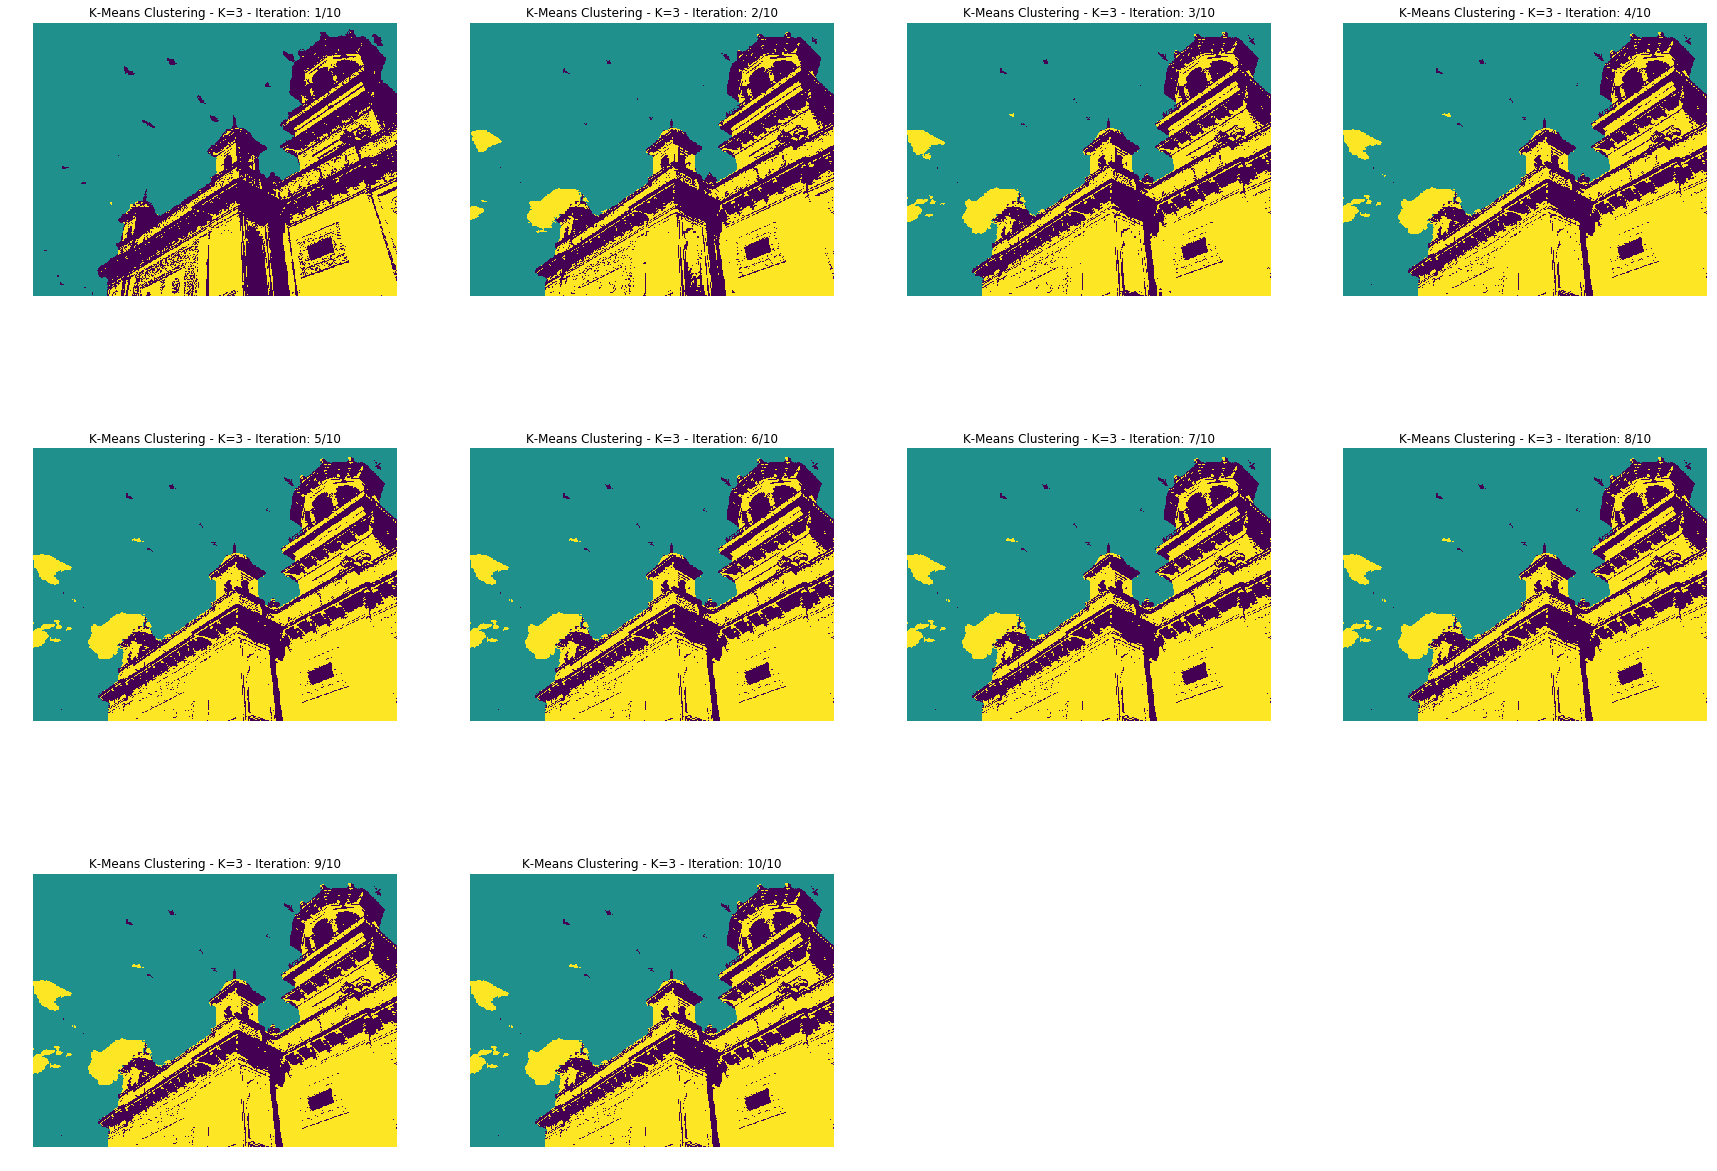

Runtime: 1.8099415302276611 s


In [5]:
start = time.time()
kMeansCluster(img_arr, 3)
print('Runtime:', time.time() - start, 's')

In [6]:
def expectationMaximum(arr, k, maxIters=10):
    """
    Expectation Maximum algorithm for image segmentation.
    
    arr: input image as numpy array
    k: number of Gaussian components
    maxIters: maximum number of times to compute
    """
    def _gaussian_distrib(x, mu, sigma):
        nom = np.power(math.e, -0.5 * np.power((x - mu)/sigma, 2))
        denom = math.sqrt(2 * math.pi) * sigma
        return np.linalg.norm(nom/denom, axis=-1)
        
    def _expectation(arr, pi, mu, sigma, k):
        h, w, d = arr.shape
        e = np.empty(shape=(h, w, k))
        for i in range(h):
            for j in range(w):
                e[i][j] = _gaussian_distrib(arr[i][j], mu, sigma)
        
        sum_e = np.sum(e * pi, axis=-1)
        sum_e = sum_e.reshape((h, w, 1))
        
        return e/sum_e
    
    def _maximization(arr, e, pi, mu, sigma, k):
        h, w, d = arr.shape
        clusters = np.argmax(e, axis=-1)
        
        for i in range(k):
            c = 0
            for j in range(h):
                for k in range(w):
                    c += e[j, k, i] * arr[j, k]
            mu[i] = c / np.sum(e[:, :, i])
            x = arr[clusters == i]
            sigma[i] = np.sqrt(np.var(x, axis=0))
            pi[i] = np.size(x) / np.size(arr)
            
        return clusters
    
    h, w, d = arr.shape
    images = []
    
    pi = np.random.rand(k)
    pi = pi / np.sum(pi)
    mu = np.random.random((k, d)) * 255.0
    sigma = np.full((k, d), 255.0/k)
        
    for i in range(maxIters):
        e = _expectation(arr, pi, mu, sigma, k)
        clusters = _maximization(arr, e, pi, mu, sigma, k)
        images.append(clusters)
    
    plotFigures(images, title='Expectation Maximum', params={'K': k})

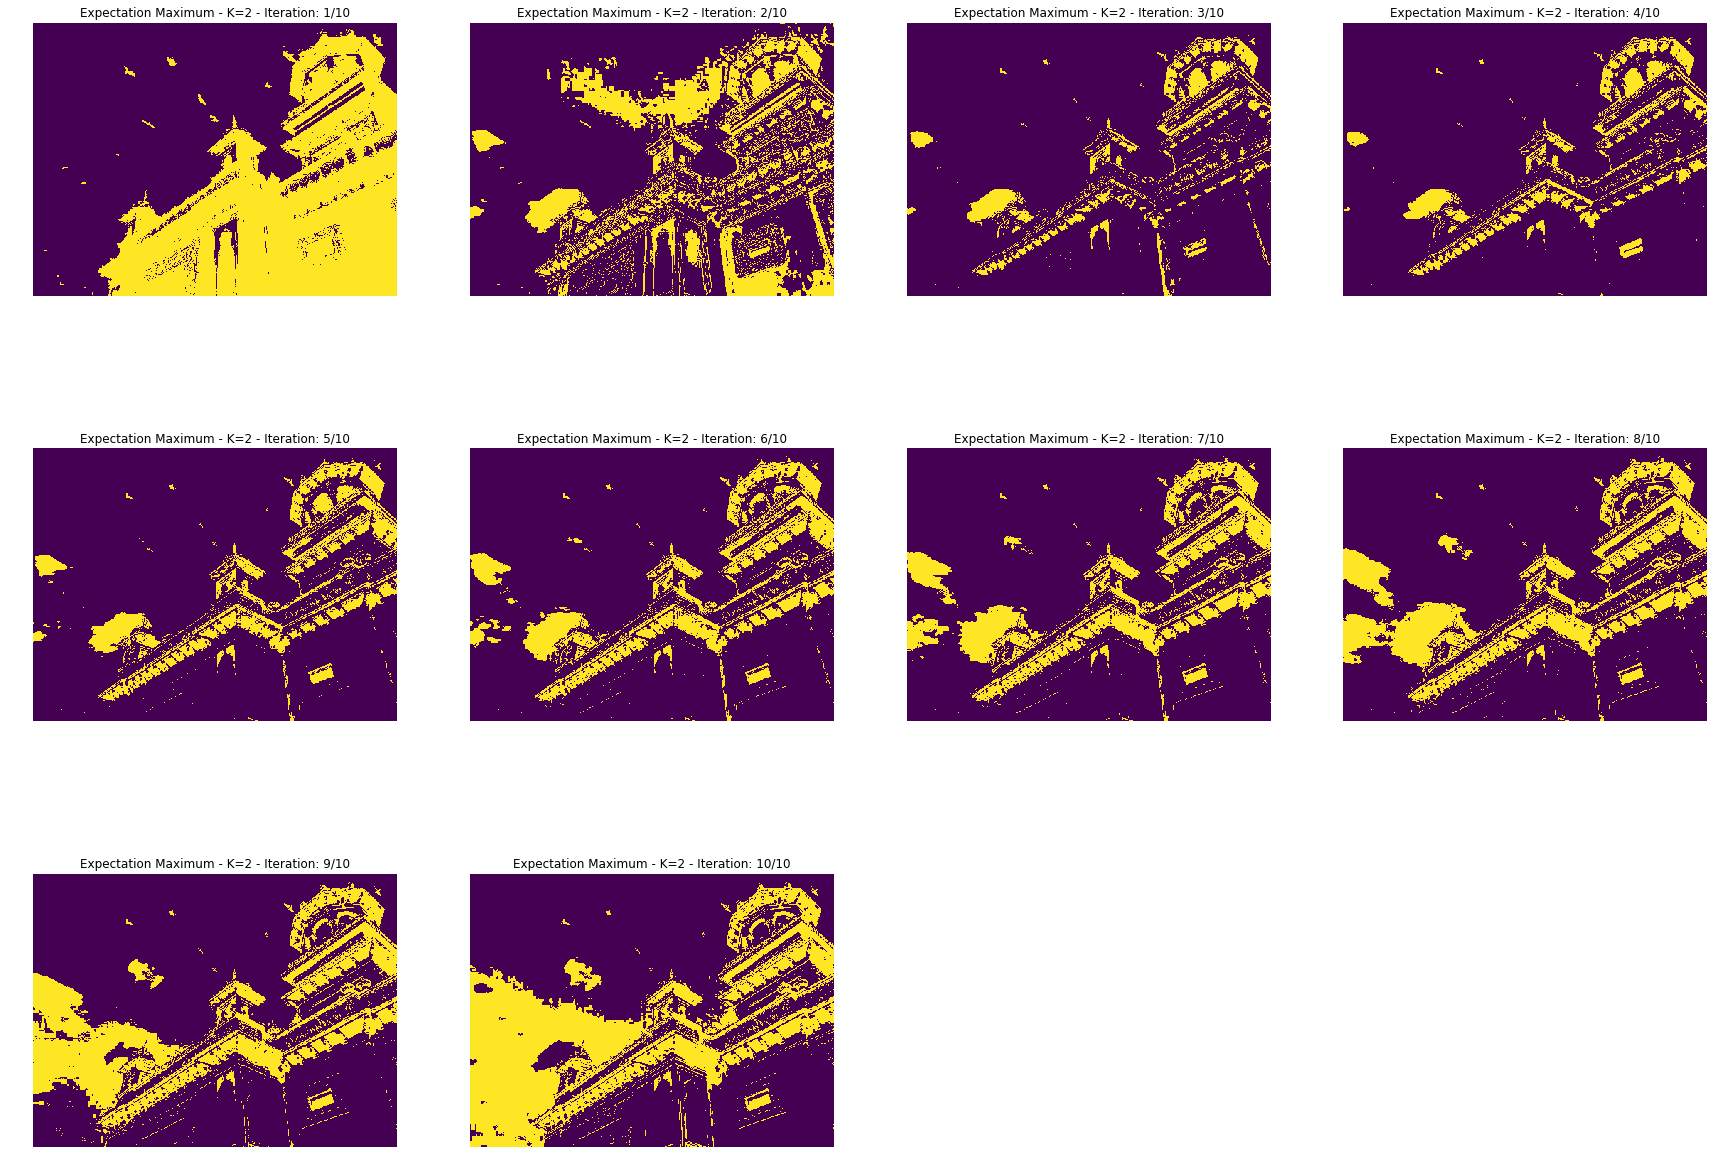

Runtime: 54.14448690414429 s


In [7]:
start = time.time()
expectationMaximum(img_arr, 2)
print('Runtime:', time.time() - start, 's')

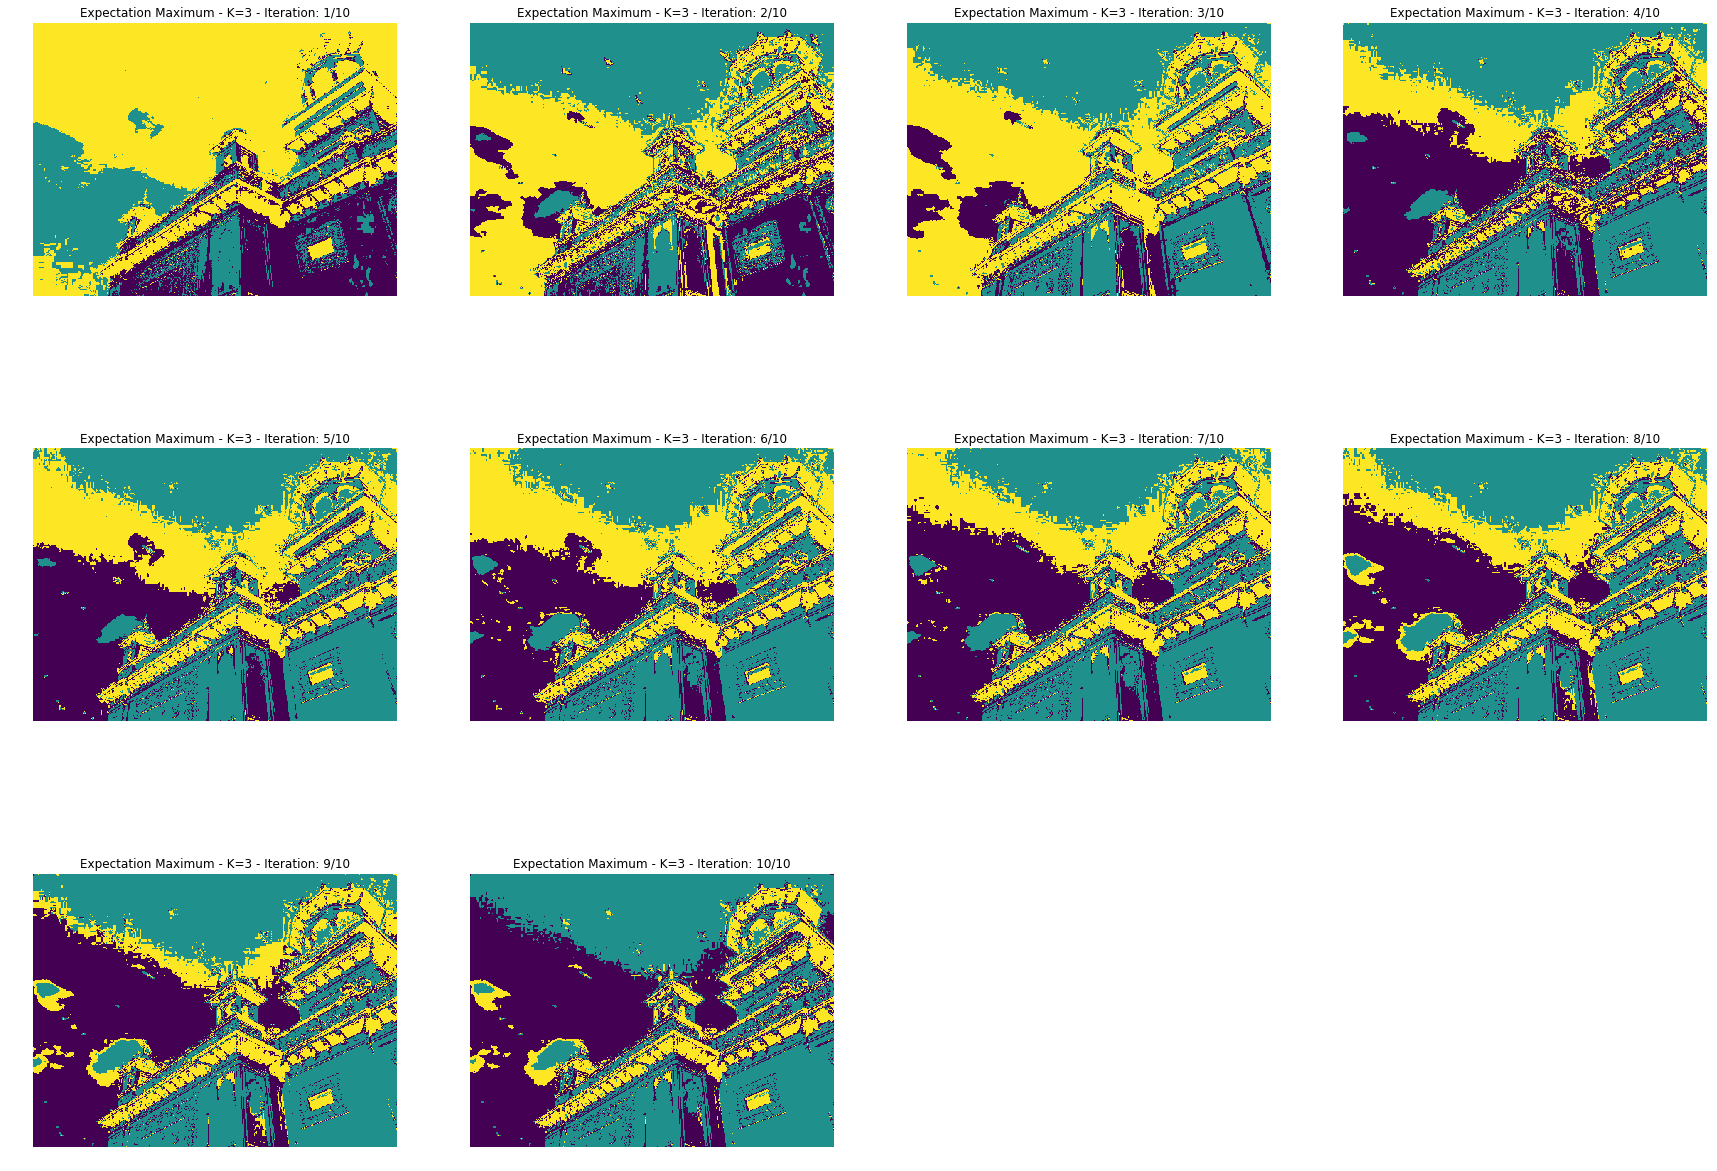

Runtime: 62.034870862960815 s


In [8]:
start = time.time()
expectationMaximum(img_arr, 3)
print('Runtime:', time.time() - start, 's')

***Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?***

We know that K-Means is essentially a variant of EM, except that K-Means is biased towards spherical clusters since it assumes clusters are spherical by assigning hard centres and using the L2 norm. While EM is based on the probability of a particular points membership to a cluster, so there is no assumption of the clusters being spherical. Therefore, K-Means and EM should give similar results in the case where the data distribution is spherical and relatively free of noise.